### Intro

Это второй ноутбук, здесь мы прогнозируем спрос на товары, не вошедшие в топ-150 по продажам и имеющие в своих временных рядах более 20% пропусков. Для их моделирования мы отталкиваемся от продаж товара по всем магазинам, с одной стороны, и продаж различных товаров в заданном магазине. На данный момент мы успели ввести только эти два типа лаговых переменных. Однако в дальнейшем мы планируем рассмотреть продажи подкатегории и категории, к которым принадлежит товар - это может помочь в прогнозировании товаров, у которых совсем нет истории продаж, а также агрегированные ценовые показатели, возможно, отношение цены товара к средней цене по категории или подкатегории.

Возможно, если какие-то признаки будут особенно успешными, мы поэкспериментируем в их применении и для топ-150 товаров. 

Сейчас все товары, не вошедшие в первую группу, прогнозируются единым пулом. Однако мы также работаем в направлении кластеризации товаров и магазинов, полагая, что если есть группы, имеющие сходные тренды, то прогнозируя их отдельно, модели будут иметь больший успех в выявлении зависимостей.

Ноутбук состоит из следующих частей: предобработка данных, генерация признаков, обучение модели, предсказание. В конце каждой части мы сформулировали промежуточные итоги



In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import optuna

c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing

In [2]:
#read file
sales = pd.read_csv('sales_df_train.csv')
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [3]:
sales.shape

(883015, 8)

In [4]:
#drop 2 inactive stores
sales = sales[~sales['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
sales.shape

(882286, 8)

In [5]:
#estimate cases where sales in units are zero and in rubles not, or vice versa
zero_nonzero_sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] == 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] != 0))]
zero_nonzero_sales.shape

(66882, 8)

In [6]:
#drop cases where sales in units are zero and in rubles not, or vice versa
sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] != 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] == 0))]
sales.shape

(815404, 8)

In [7]:
#drop negative sales
sales = sales[(sales['pr_sales_in_rub'] >= 0) & (sales['pr_sales_in_units'] >= 0) & (sales['pr_promo_sales_in_rub'] >= 0) & (sales['pr_promo_sales_in_units'] >= 0)]
sales.shape

(815334, 8)

In [8]:
#concat item-store pair into single unit
sales['store_item'] = sales['st_id'].str.cat(sales['pr_sku_id'], sep='-')
sales['store_item'].nunique()

6130

In [9]:
#glue together promo and non-promo sales of one item-store pair on same day
oneline = sales.groupby(['store_item', 'date'])[['pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline.shape

(661192, 5)

In [10]:
#detect top150 item-store pairs
by_pair = oneline.groupby('store_item')[['pr_sales_in_units', 'pr_sales_in_rub']].agg(['sum', 'count'])
all_sales = by_pair[('pr_sales_in_rub', 'sum')].sum()
by_pair['all_sales_share'] = by_pair[('pr_sales_in_rub', 'sum')] / all_sales * 100
by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150)

pr_sales_in_units        \
                                                                 sum count   
store_item                                                                   
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...           51500.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...           42088.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...           34255.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...           32923.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...           29678.0   352   
...                                                              ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...            5469.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...            5417.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...            5399.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...            5364.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...            5337.0   192   

                                                   pr_sales_in_rub        \
                                                               sum count   
store_item                                                                 
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        879274.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...       1999391.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...       1070819.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...       4187731.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        963222.0   352   
...                                                            ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        324306.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...         84293.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        643395.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        328648.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        913631.0   192   

                                                   all_sales_share  
                                                                    
store_item                                                          
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        0.168569  
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...        0.383311  
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...        0.205291  
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...        0.802847  
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        0.184663  
...                                                            ...  
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        0.062174  
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...        0.016160  
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        0.123348  
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        0.063006  
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        0.175156  

[150 rows x 5 columns]

In [11]:
#separate top 150
by_pair = by_pair.reset_index()
top150 = by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150)
no_top150 = by_pair[~by_pair['store_item'].isin(top150['store_item'])]
most_frequent = no_top150[no_top150[('pr_sales_in_units', 'count')] >= 352*0.8]
flagman = pd.concat([top150, most_frequent])
flagman.shape

(857, 6)

In [12]:
#get no flagman pairs
rest = by_pair[~by_pair['store_item'].isin(flagman['store_item'])]
rest.shape

(5273, 6)

In [13]:
oneline = oneline.reset_index()
oneline.head()

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-07,1,1.0,81.0,1.0,81.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-11,1,1.0,81.0,1.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-12,1,1.0,81.0,1.0,81.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-29,0,1.0,146.0,0.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-05-24,0,1.0,146.0,0.0,0.0


In [14]:
#make train dataset out of top50 and their sales
train = oneline[oneline['store_item'].isin(rest['store_item'])]
train.shape

(387062, 7)

In [15]:
#i suppose in this set we should separate store from item
separate_product_store = sales[['pr_sku_id', 'st_id', 'store_item']].drop_duplicates(subset='store_item')
separate_product_store.shape

(6130, 3)

In [16]:
train = train.merge(separate_product_store, how='left', on='store_item')
train = train[['pr_sku_id', 'st_id', 'date', 'pr_sales_in_units']]
train.shape

(387062, 4)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387062 entries, 0 to 387061
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pr_sku_id          387062 non-null  object 
 1   st_id              387062 non-null  object 
 2   date               387062 non-null  object 
 3   pr_sales_in_units  387062 non-null  float64
dtypes: float64(1), object(3)
memory usage: 11.8+ MB


In [18]:
train['date'] = pd.to_datetime(train['date']).dt.normalize()

In [19]:
train['date'].describe()

count                           387062
mean     2023-01-25 10:16:32.027116800
min                2022-08-01 00:00:00
25%                2022-10-28 00:00:00
50%                2023-01-26 00:00:00
75%                2023-04-26 00:00:00
max                2023-07-18 00:00:00
Name: date, dtype: object

Предобработка практически полностью повторяет предобработку для первой модели, за тем исключением, что здесь мы, напротив, выбеляем товары, не входящие в топ и не являющиеся частотными, а также возвращаемся в датасете от объединенного столбца товар-магазин к отдельным товар и магазин. Это важно, поскольку далее мы будем работать отдельно с признаками товаров и магазинов.

Шаги предобработки, дублирующие первый ноутбук:

* удалили два неактивных магазина. Для них не требуется прогноз, и данных по ним мало - едва ли они серьезно на что-то повлияют

* удалили любые отрицательные продажи. Вероятно, это возвраты товаров, не превысившие в этот день продажи. Возвраты не характеризуют спрос, являющийся нашей целью в данной работе

* удалили случаи, когда продажи в штуках равны нулю, а в рублях нет. Мы полагаем, что это связано с округлением. Все данные в датасете округлены до целых. Если в день было продано менее 0.5 кг весового товара, он округлится до нуля, при этом продажи в рублях ненулевые. Эту гипотезу подтверждает то, что у всех таких товаров один и тот же тип (кг/штуки). Это соответствует цели исследования: продажи менее единицы отражают спрос, близкий к нулю

* удалили случаи, когда продажи в рублях нулевые, а в штуках нет. Это либо ошибки системы, либо покупатель по какой-то акции получил товар бесплатно, что в обоих случаях не отражает реальный спрос

* объединили продажи одного товара в одном магазине в один день по промо и без в одну строку

### Feature engineering

In [20]:
#and this full set we shall use to get lags by product. separate store from item and format date
byproduct = oneline.groupby(['store_item', 'date'])['pr_sales_in_units'].sum().reset_index()
byproduct = byproduct.merge(separate_product_store, how='left', on='store_item')
byproduct = byproduct[['pr_sku_id', 'st_id', 'date', 'pr_sales_in_units']]
byproduct['date'] = pd.to_datetime(byproduct['date']).dt.normalize()
byproduct.head()

,pr_sku_id,st_id,date,pr_sales_in_units
0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-07,1.0
1,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-11,1.0
2,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-12,1.0
3,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-29,1.0
4,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-05-24,1.0


In [21]:
#check shape - its the shape of the full sales set after we glued together promo and non-promo for the same day
byproduct.shape

(661192, 4)

In [22]:
#sales of one product in all stores by day
byproduct = byproduct.groupby(['pr_sku_id', 'date'])['pr_sales_in_units'].sum().reset_index()
byproduct.shape

(277472, 3)

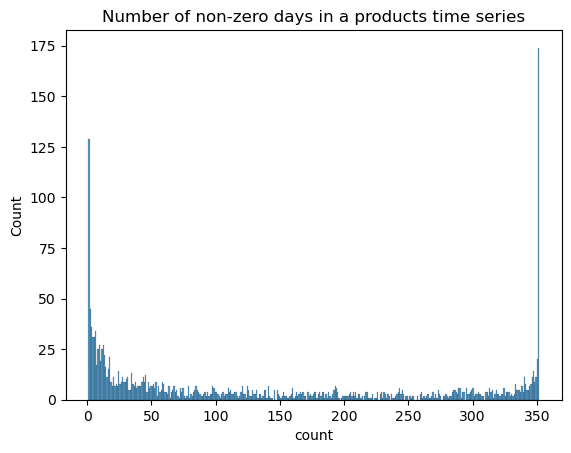

In [23]:
series_density = byproduct['pr_sku_id'].value_counts()
sns.histplot(series_density, bins=350)
plt.title('Number of non-zero days in a products time series');

Очень много товаров продавалось всего один день. Вообще разреженные временные ряды преобладают. Сейчас мы достроим их нулями и получим очень много нулей (но не так много, как если бы единицей моделирования оставался товар-магазин)

In [24]:
#number of unique products
byproduct['pr_sku_id'].nunique()

1973

In [25]:
#insert zeros for missing dates
byproduct = byproduct.sort_values(by='date')
bypr_pivoted = byproduct.pivot(index='pr_sku_id', columns='date', values='pr_sales_in_units').fillna(0)

bypr_long = bypr_pivoted.stack().reset_index()
bypr_long = bypr_long.rename(columns={'level_1': 'date', 0: 'sku'})
bypr_long.head()

,pr_sku_id,date,sku
0,002c3a40ac50dc870f1ff386f11f5bae,2022-08-01,0.0
1,002c3a40ac50dc870f1ff386f11f5bae,2022-08-02,0.0
2,002c3a40ac50dc870f1ff386f11f5bae,2022-08-03,0.0
3,002c3a40ac50dc870f1ff386f11f5bae,2022-08-04,0.0
4,002c3a40ac50dc870f1ff386f11f5bae,2022-08-05,0.0


In [26]:
#assert number of lines equals 1973 items * 352 days
bypr_long.shape, 1973*352

((694496, 3), 694496)

In [27]:
#add lag columns
shifted = bypr_long.set_index(['pr_sku_id', 'date'])
new = shifted.copy()

for i in range(21):
    shifted_i = shifted.groupby(level="pr_sku_id").shift(i+1)
    new = new.join(shifted_i.rename(columns=lambda x: x+f"_lag_{i+1}"))
new.head()

sku  sku_lag_1  sku_lag_2  \
pr_sku_id                        date                                    
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01  0.0        NaN        NaN   
                                 2022-08-02  0.0        0.0        NaN   
                                 2022-08-03  0.0        0.0        0.0   
                                 2022-08-04  0.0        0.0        0.0   
                                 2022-08-05  0.0        0.0        0.0   

                                             sku_lag_3  sku_lag_4  sku_lag_5  \
pr_sku_id                        date                                          
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01        NaN        NaN        NaN   
                                 2022-08-02        NaN        NaN        NaN   
                                 2022-08-03        NaN        NaN        NaN   
                                 2022-08-04        0.0        NaN        NaN   
                                 2022-08-05        0.0        0.0        NaN   

                                             sku_lag_6  sku_lag_7  sku_lag_8  \
pr_sku_id                        date                                          
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01        NaN        NaN        NaN   
                                 2022-08-02        NaN        NaN        NaN   
                                 2022-08-03        NaN        NaN        NaN   
                                 2022-08-04        NaN        NaN        NaN   
                                 2022-08-05        NaN        NaN        NaN   

                                             sku_lag_9  ...  sku_lag_12  \
pr_sku_id                        date                   ...               
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01        NaN  ...         NaN   
                                 2022-08-02        NaN  ...         NaN   
                                 2022-08-03        NaN  ...         NaN   
                                 2022-08-04        NaN  ...         NaN   
                                 2022-08-05        NaN  ...         NaN   

                                             sku_lag_13  sku_lag_14  \
pr_sku_id                        date                                 
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01         NaN         NaN   
                                 2022-08-02         NaN         NaN   
                                 2022-08-03         NaN         NaN   
                                 2022-08-04         NaN         NaN   
                                 2022-08-05         NaN         NaN   

                                             sku_lag_15  sku_lag_16  \
pr_sku_id                        date                                 
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01         NaN         NaN   
                                 2022-08-02         NaN         NaN   
                                 2022-08-03         NaN         NaN   
                                 2022-08-04         NaN         NaN   
                                 2022-08-05         NaN         NaN   

                                             sku_lag_17  sku_lag_18  \
pr_sku_id                        date                                 
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01         NaN         NaN   
                                 2022-08-02         NaN         NaN   
                                 2022-08-03         NaN         NaN   
                                 2022-08-04         NaN         NaN   
                                 2022-08-05         NaN         NaN   

                                             sku_lag_19  sku_lag_20  \
pr_sku_id                        date                                 
002c3a40ac50dc870f1ff386f11f5bae 2022-08-01         NaN         NaN   
                                 2022-08-02         NaN         NaN   
                                 2022-08-03         NaN         NaN   
                             

In [28]:
#delete nans where there's no lag data (start of period)
new['na_sum'] = new.isna().sum(axis=1)
new = new[new['na_sum'] == 0]
new = new.drop('na_sum', axis=1)
new.shape

(653063, 22)

In [29]:
#look at the edge between units to make sure lags don't mix up
new[659:666]

sku  sku_lag_1  sku_lag_2  \
pr_sku_id                        date                                    
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16  2.0        3.0        4.0   
                                 2023-07-17  3.0        2.0        3.0   
                                 2023-07-18  3.0        3.0        2.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22  0.0        0.0        0.0   
                                 2022-08-23  0.0        0.0        0.0   
                                 2022-08-24  0.0        0.0        0.0   
                                 2022-08-25  0.0        0.0        0.0   

                                             sku_lag_3  sku_lag_4  sku_lag_5  \
pr_sku_id                        date                                          
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16        1.0        0.0        0.0   
                                 2023-07-17        4.0        1.0        0.0   
                                 2023-07-18        3.0        4.0        1.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22        0.0        0.0        0.0   
                                 2022-08-23        0.0        0.0        0.0   
                                 2022-08-24        0.0        0.0        0.0   
                                 2022-08-25        0.0        0.0        0.0   

                                             sku_lag_6  sku_lag_7  sku_lag_8  \
pr_sku_id                        date                                          
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16        0.0        0.0        0.0   
                                 2023-07-17        0.0        0.0        0.0   
                                 2023-07-18        0.0        0.0        0.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22        0.0        0.0        0.0   
                                 2022-08-23        0.0        0.0        0.0   
                                 2022-08-24        0.0        0.0        0.0   
                                 2022-08-25        0.0        0.0        0.0   

                                             sku_lag_9  ...  sku_lag_12  \
pr_sku_id                        date                   ...               
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16        0.0  ...         0.0   
                                 2023-07-17        0.0  ...         0.0   
                                 2023-07-18        0.0  ...         0.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22        0.0  ...         0.0   
                                 2022-08-23        0.0  ...         0.0   
                                 2022-08-24        0.0  ...         0.0   
                                 2022-08-25        0.0  ...         0.0   

                                             sku_lag_13  sku_lag_14  \
pr_sku_id                        date                                 
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16         0.0         0.0   
                                 2023-07-17         0.0         0.0   
                                 2023-07-18         0.0         0.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22         0.0         0.0   
                                 2022-08-23         0.0         0.0   
                                 2022-08-24         0.0         0.0   
                                 2022-08-25         0.0         0.0   

                                             sku_lag_15  sku_lag_16  \
pr_sku_id                        date                                 
0045ebdb1069ff4b3dd3efe628c39cd3 2023-07-16         0.0         0.0   
                                 2023-07-17         0.0         0.0   
                                 2023-07-18         0.0         0.0   
005c52de11abaf8e0a9714b24415ce34 2022-08-22         0.0         0.0   
                                 2022-08-23         0.0         0.0   
                                 2022-08-24         0.0         0.0   
                                 2022-08-25         

In [30]:
byproduct = new.reset_index()
byproduct['date']

0        2022-08-22
1        2022-08-23
2        2022-08-24
3        2022-08-25
4        2022-08-26
            ...    
653058   2023-07-14
653059   2023-07-15
653060   2023-07-16
653061   2023-07-17
653062   2023-07-18
Name: date, Length: 653063, dtype: datetime64[ns]

In [31]:
#get new sold column, it's target
train = train.rename(columns={'pr_sales_in_units': 'sold'})
train.shape

(387062, 4)

In [32]:
#add lags. remember thei're not for store-item but for item in all stores that day
with_lags = train.merge(byproduct, on=['pr_sku_id', 'date'], how='left')
with_lags.shape

(387062, 26)

In [33]:
#lets get lags by store
bystore = oneline.groupby(['store_item', 'date'])['pr_sales_in_units'].sum().reset_index()
bystore = bystore.merge(separate_product_store, how='left', on='store_item')
bystore = bystore[['pr_sku_id', 'st_id', 'date', 'pr_sales_in_units']]
bystore['date'] = pd.to_datetime(bystore['date']).dt.normalize()
bystore.head()

,pr_sku_id,st_id,date,pr_sales_in_units
0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-07,1.0
1,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-11,1.0
2,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-12,1.0
3,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-04-29,1.0
4,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75,2023-05-24,1.0


In [34]:
#sales in every store by day
bystore = bystore.groupby(['st_id', 'date'])['pr_sales_in_units'].sum().reset_index()
bystore.shape

(3156, 3)

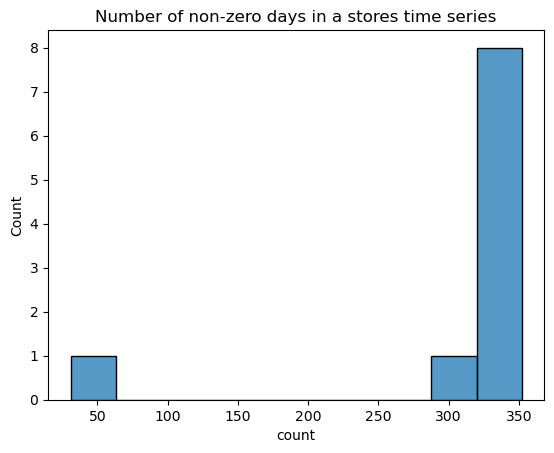

In [35]:
series_density = bystore['st_id'].value_counts()
sns.histplot(series_density, bins=10)
plt.title('Number of non-zero days in a stores time series');

В одном магазине очень мало активных дней, в одном - почти все, в 8 магазинах - во все дни есть продажи

In [36]:
bystore['st_id'].value_counts().sort_values()

st_id
084a8a9aa8cced9175bd07bc44998e75     31
bd470ca955d9497bbcb808e59952fffc    309
16a5cdae362b8d27a1d8f8c7b78b4330    352
1ecfb463472ec9115b10c292ef8bc986    352
42a0e188f5033bc65bf8d78622277c4e    352
53e19f3dbb211f20b20b45668303c1b6    352
6364d3f0f495b6ab9dcf8d3b5c6e0b01    352
c81e728d9d4c2f636f067f89cc14862c    352
f7e6c85504ce6e82442c770f7c8606f0    352
fa7cdfad1a5aaf8370ebeda47a1ff1c3    352
Name: count, dtype: int64

In [37]:
bystore[bystore['st_id'] == '084a8a9aa8cced9175bd07bc44998e75']

,st_id,date,pr_sales_in_units
0,084a8a9aa8cced9175bd07bc44998e75,2023-03-26,3.0
1,084a8a9aa8cced9175bd07bc44998e75,2023-03-27,1.0
2,084a8a9aa8cced9175bd07bc44998e75,2023-03-30,3.0
3,084a8a9aa8cced9175bd07bc44998e75,2023-04-01,3.0
4,084a8a9aa8cced9175bd07bc44998e75,2023-04-02,2.0
5,084a8a9aa8cced9175bd07bc44998e75,2023-04-04,2.0
6,084a8a9aa8cced9175bd07bc44998e75,2023-04-06,1.0
7,084a8a9aa8cced9175bd07bc44998e75,2023-04-07,3.0
8,084a8a9aa8cced9175bd07bc44998e75,2023-04-10,1.0
9,084a8a9aa8cced9175bd07bc44998e75,2023-04-11,2.0


In [38]:
sample_sub = pd.read_csv('sales_submission.csv')
sample_sub[sample_sub['st_id'] == '084a8a9aa8cced9175bd07bc44998e75']

,st_id,pr_sku_id,date,target


В сабмите этого магазина нет, продажи маленькие и закончились какое-то время назад. Можно его удалить, но я оставлю для общих сумм, раз не удалила сразу. Я думаю, цифры слишком маленькие, чтобы на что-то влиять

In [39]:
#insert zeros for missing dates
bystore = bystore.sort_values(by='date')
byst_pivoted = bystore.pivot(index='st_id', columns='date', values='pr_sales_in_units').fillna(0)

byst_long = byst_pivoted.stack().reset_index()
byst_long = byst_long.rename(columns={'level_1': 'date', 0: 'store'})
byst_long.head()

,st_id,date,store
0,084a8a9aa8cced9175bd07bc44998e75,2022-08-01,0.0
1,084a8a9aa8cced9175bd07bc44998e75,2022-08-02,0.0
2,084a8a9aa8cced9175bd07bc44998e75,2022-08-03,0.0
3,084a8a9aa8cced9175bd07bc44998e75,2022-08-04,0.0
4,084a8a9aa8cced9175bd07bc44998e75,2022-08-05,0.0


In [40]:
#assert number of lines equals 10 stores * 352 days
byst_long.shape, 10*352

((3520, 3), 3520)

In [41]:
#add lag columns
shifted = byst_long.set_index(['st_id', 'date'])
new = shifted.copy()

for i in range(21):
    shifted_i = shifted.groupby(level="st_id").shift(i+1)
    new = new.join(shifted_i.rename(columns=lambda x: x+f"_lag_{i+1}"))
new.head()

store  store_lag_1  store_lag_2  \
st_id                            date                                          
084a8a9aa8cced9175bd07bc44998e75 2022-08-01    0.0          NaN          NaN   
                                 2022-08-02    0.0          0.0          NaN   
                                 2022-08-03    0.0          0.0          0.0   
                                 2022-08-04    0.0          0.0          0.0   
                                 2022-08-05    0.0          0.0          0.0   

                                             store_lag_3  store_lag_4  \
st_id                            date                                   
084a8a9aa8cced9175bd07bc44998e75 2022-08-01          NaN          NaN   
                                 2022-08-02          NaN          NaN   
                                 2022-08-03          NaN          NaN   
                                 2022-08-04          0.0          NaN   
                                 2022-08-05          0.0          0.0   

                                             store_lag_5  store_lag_6  \
st_id                            date                                   
084a8a9aa8cced9175bd07bc44998e75 2022-08-01          NaN          NaN   
                                 2022-08-02          NaN          NaN   
                                 2022-08-03          NaN          NaN   
                                 2022-08-04          NaN          NaN   
                                 2022-08-05          NaN          NaN   

                                             store_lag_7  store_lag_8  \
st_id                            date                                   
084a8a9aa8cced9175bd07bc44998e75 2022-08-01          NaN          NaN   
                                 2022-08-02          NaN          NaN   
                                 2022-08-03          NaN          NaN   
                                 2022-08-04          NaN          NaN   
                                 2022-08-05          NaN          NaN   

                                             store_lag_9  ...  store_lag_12  \
st_id                            date                     ...                 
084a8a9aa8cced9175bd07bc44998e75 2022-08-01          NaN  ...           NaN   
                                 2022-08-02          NaN  ...           NaN   
                                 2022-08-03          NaN  ...           NaN   
                                 2022-08-04          NaN  ...           NaN   
                                 2022-08-05          NaN  ...           NaN   

                                             store_lag_13  store_lag_14  \
st_id                            date                                     
084a8a9aa8cced9175bd07bc44998e75 2022-08-01           NaN           NaN   
                                 2022-08-02           NaN           NaN   
                                 2022-08-03           NaN           NaN   
                                 2022-08-04           NaN           NaN   
                                 2022-08-05           NaN           NaN   

                                             store_lag_15  store_lag_16  \
st_id                            date                                     
084a8a9aa8cced9175bd07bc44998e75 2022-08-01           NaN           NaN   
                                 2022-08-02           NaN           NaN   
                                 2022-08-03           NaN           NaN   
                                 2022-08-04           NaN           NaN   
                                 2022-08-05           NaN           NaN   

                                             store_lag_17  store_lag_18  \
st_id                            date                                     
084a8a9aa8cced9175bd07bc44998e75 2022-08-01           NaN           NaN   
                                 2022-08-02           NaN           NaN   
                                 2022-08-0

In [42]:
#delete nans where there's no lag data (start of period)
new['na_sum'] = new.isna().sum(axis=1)
new = new[new['na_sum'] == 0]
new = new.drop('na_sum', axis=1)
new.shape

(3310, 22)

In [43]:
#look at the edge between units to make sure lags don't mix up
new[659:666]

store  store_lag_1  store_lag_2  \
st_id                            date                                           
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16  2688.0       3690.0       3837.0   
                                 2023-07-17  1810.0       2688.0       3690.0   
                                 2023-07-18  2161.0       1810.0       2688.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22   427.0        263.0        337.0   
                                 2022-08-23   485.0        427.0        263.0   
                                 2022-08-24   469.0        485.0        427.0   
                                 2022-08-25   402.0        469.0        485.0   

                                             store_lag_3  store_lag_4  \
st_id                            date                                   
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16       3074.0       2053.0   
                                 2023-07-17       3837.0       3074.0   
                                 2023-07-18       3690.0       3837.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22        527.0        577.0   
                                 2022-08-23        337.0        527.0   
                                 2022-08-24        263.0        337.0   
                                 2022-08-25        427.0        263.0   

                                             store_lag_5  store_lag_6  \
st_id                            date                                   
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16       2132.0       2049.0   
                                 2023-07-17       2053.0       2132.0   
                                 2023-07-18       3074.0       2053.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22        401.0        376.0   
                                 2022-08-23        577.0        401.0   
                                 2022-08-24        527.0        577.0   
                                 2022-08-25        337.0        527.0   

                                             store_lag_7  store_lag_8  \
st_id                            date                                   
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16       2443.0       3398.0   
                                 2023-07-17       2049.0       2443.0   
                                 2023-07-18       2132.0       2049.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22        518.0        344.0   
                                 2022-08-23        376.0        518.0   
                                 2022-08-24        401.0        376.0   
                                 2022-08-25        577.0        401.0   

                                             store_lag_9  ...  store_lag_12  \
st_id                            date                     ...                 
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16       3610.0  ...        2153.0   
                                 2023-07-17       3398.0  ...        2143.0   
                                 2023-07-18       2443.0  ...        2442.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22        332.0  ...         410.0   
                                 2022-08-23        344.0  ...         341.0   
                                 2022-08-24        518.0  ...         407.0   
                                 2022-08-25        376.0  ...         332.0   

                                             store_lag_13  store_lag_14  \
st_id                            date                                     
16a5cdae362b8d27a1d8f8c7b78b4330 2023-07-16        1873.0        2576.0   
                                 2023-07-17        2153.0        1873.0   
                                 2023-07-18        2143.0        2153.0   
1ecfb463472ec9115b10c292ef8bc986 2022-08-22         403.0         422.0   
                                 2022-08-23         410.0         403.0   
                                 2022-08-24         341.0         410.0   
                              

In [44]:
bystore = new.reset_index()

In [45]:
#add store lags
with_store_lags = with_lags.merge(bystore, on=['st_id', 'date'], how='left')
with_store_lags.shape

(387062, 48)

In [46]:
#add features of day-of-week, day-of-month, week, month, season
with_store_lags['dow'] = with_store_lags['date'].dt.dayofweek
with_store_lags['day'] = with_store_lags['date'].dt.day
with_store_lags['week'] = with_store_lags['date'].dt.isocalendar().week.astype('int32')
with_store_lags['month'] = with_store_lags['date'].dt.month
with_store_lags['season'] = with_store_lags['date'].dt.quarter  

Работа над признаками для этой модели только начата. В это разделе мы добавили к обучающему датасету три группы признаков:

1) лаговые переменные продаж товара суммарно по всем магазинам. Если данных о продажах товара в данном магазине недостаточно, переходим к суммарным продажам по всей сети

2) лаговые переменные продаж всех товаров в данном магазине. Это дает информацию о посещаемости и обороте магазина в конкретный день

3) календарные фичи: день недели, день месяца, номер недели, месяц, время года

### Model fitting

In [47]:
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [48]:
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [49]:
def lgbm_cross_val(cat_features, cols_to_drop, df=new, h=14, cv=5):
    wapes = []
    for i in range(cv):
        end_train = df['date'].max() - pd.Timedelta(days=h*(i+1))
        end_valid = df['date'].max() - pd.Timedelta(days=h*i)
        train = df[df['date'] <= end_train]
        valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['sold']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['sold']

        eval_set = [(X_valid, y_valid)]
        print(end_train, end_valid)
        print(X_train.shape, X_valid.shape)

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])


        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )

        preds = lgbm_reg.predict(X_valid)
        lgbm_wape = wape(y_valid, preds)
        
        plot_df = pd.DataFrame({'date': pd.date_range(start=(end_train+pd.Timedelta(days=1)), end=end_valid), 'y_true': y_valid[:h], 'y_pred': preds[:h]})
        
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
        
        print(f"LGBM CV step {i+1} WAPE: {lgbm_wape}")
        wapes.append(lgbm_wape)

        
    plotImp(lgbm_reg, X_train)

    return(wapes)

2023-07-04 00:00:00 2023-07-18 00:00:00
(370307, 49) (16755, 49)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 27.9553
[200]	valid_0's l2: 26.9571
[300]	valid_0's l2: 26.809
[400]	valid_0's l2: 26.6045
[500]	valid_0's l2: 26.4465
[600]	valid_0's l2: 26.2428
[700]	valid_0's l2: 26.3127


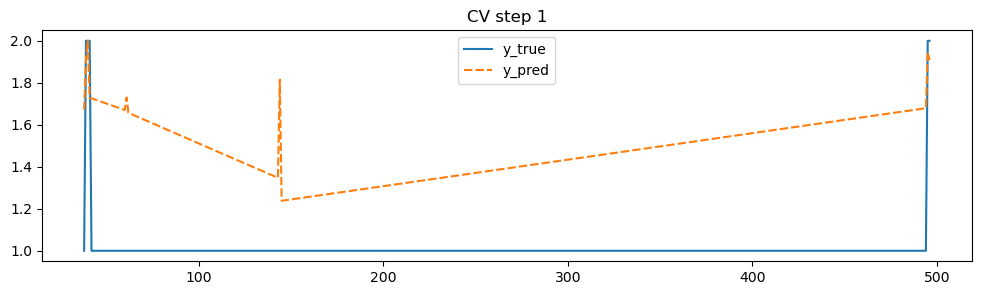

LGBM CV step 1 WAPE: 0.5073568182150096
2023-06-20 00:00:00 2023-07-04 00:00:00
(353739, 49) (16568, 49)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 20.7923
[200]	valid_0's l2: 20.2817
[300]	valid_0's l2: 20.2479
[400]	valid_0's l2: 20.3281
[500]	valid_0's l2: 20.2542


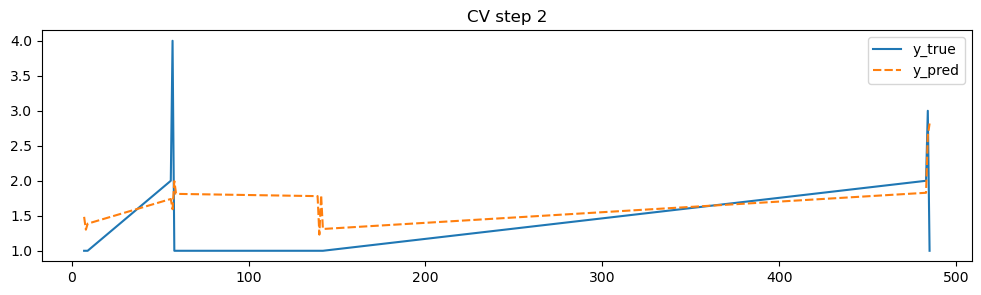

LGBM CV step 2 WAPE: 0.5225030380978819
2023-06-06 00:00:00 2023-06-20 00:00:00
(337483, 49) (16256, 49)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 26.8806
[200]	valid_0's l2: 26.5519
[300]	valid_0's l2: 26.4877
[400]	valid_0's l2: 26.231
[500]	valid_0's l2: 26.3103


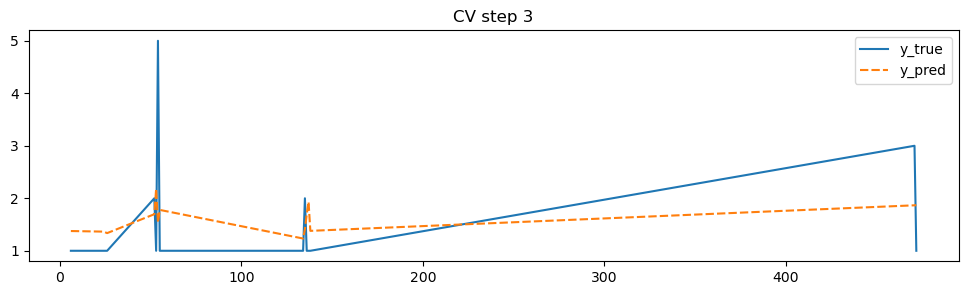

LGBM CV step 3 WAPE: 0.5221022493423378
2023-05-23 00:00:00 2023-06-06 00:00:00
(321717, 49) (15766, 49)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 21.5102
[200]	valid_0's l2: 21.2622
[300]	valid_0's l2: 21.3271


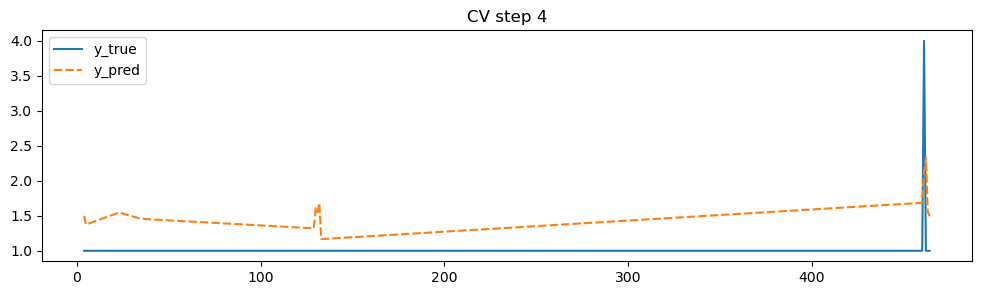

LGBM CV step 4 WAPE: 0.5245621127739302
2023-05-09 00:00:00 2023-05-23 00:00:00
(305868, 49) (15849, 49)


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 28.0562
[200]	valid_0's l2: 29.0725


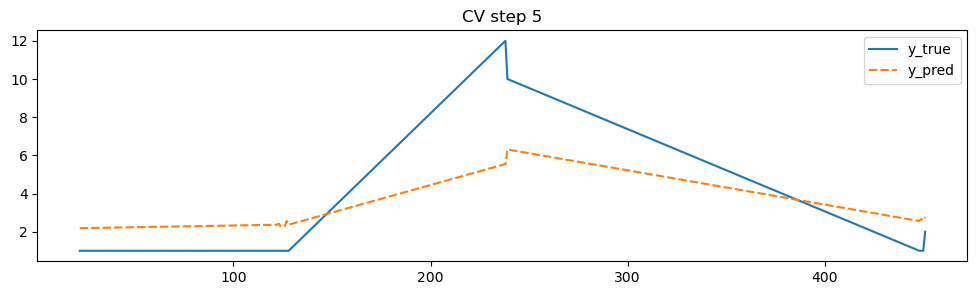

LGBM CV step 5 WAPE: 0.6099162380863477


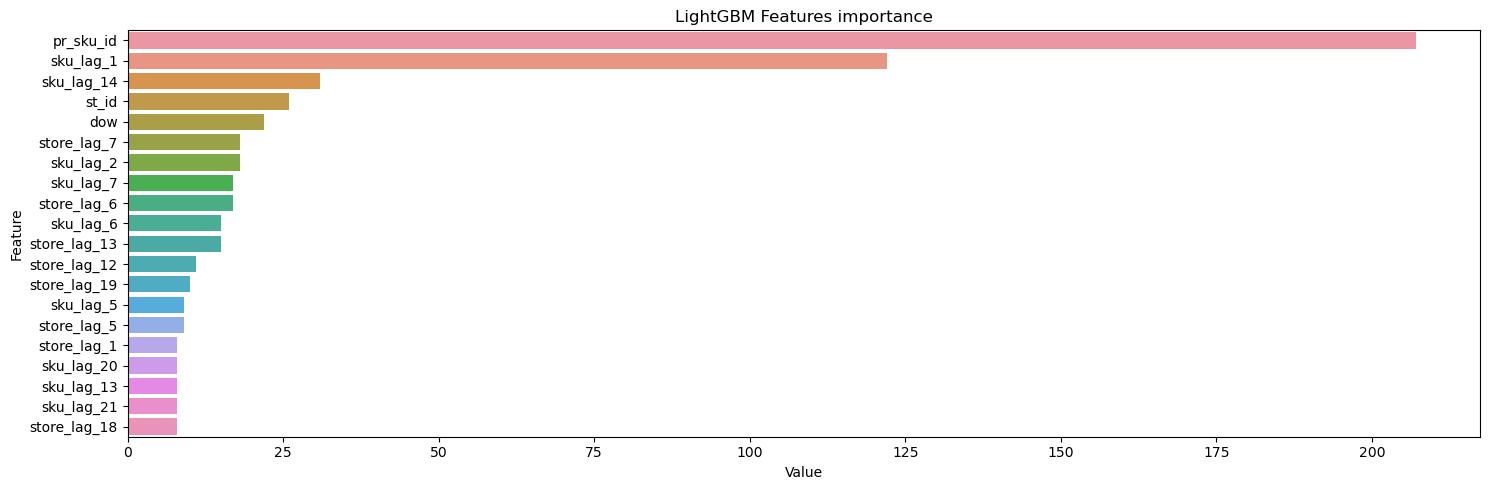

In [50]:
lgbm_wapes = lgbm_cross_val(df=with_store_lags, cat_features=['pr_sku_id', 'st_id', 'season', 'dow'], cols_to_drop=['date', 'sold', 'sku', 'store'])

In [51]:
print(f'LGBM mean WAPE = {np.mean(lgbm_wapes)}')

LGBM mean WAPE = 0.5372880913031014


Итерация 1

* Фичи: товар, магазин, 21 лаг (Тлаг)
* ВЭЙП: 0.5387446485520166
* Важное: товар, Тлаг 1, магазин, Тлаги 14, 7, 2, 6, 12, 13, 5, 9

Итерация 2

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг)
* ВЭЙП: 0.542979568453861
* Важное: товар, Тлаги 1, 14, 7, магазин, Тлаг 6, Млаги 6, 7, 13, 14
* Вывод: стало хуже. Пока оставим магазинные лаги, но когда фичей будет больше, попробуем их убрать

Итерация 3

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг), календарные
* ВЭЙП: 0.5372880913031014
* Важное: товар, Тлаги 1, 14, магазин, день недели, Млаг 7, Тлаги 2, 7, Млаг 6, Тлаг 6, Млаг 13
* Вывод: метрика немного улучшилась. Календарные фичи нужны

In [52]:
def objective(trial, data=with_store_lags, cols_to_drop=['date', 'sold', 'sku', 'store'], cat_features=['pr_sku_id', 'st_id', 'season', 'dow']):
    
    end_train = data['date'].max() - pd.Timedelta(days=14)
    train = data[data['date'] <= end_train]
    valid = data[data['date'] > end_train]

    train_x = train.drop(cols_to_drop, axis=1)
    train_y = train['sold']
    test_x = valid.drop(cols_to_drop, axis=1)
    test_y = valid['sold']

    cat_idx = [train_x.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        train_x[col] = pd.Categorical(train_x[col])
        test_x[col] = pd.Categorical(test_x[col])

    param = {
        'metric': 'mae', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,categorical_feature=cat_idx,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(test_x)

    trial.set_user_attr(key="best_booster", value=model)
    
    return wape(test_y, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-09-30 21:53:19,547] A new study created in memory with name: no-name-3663d4e0-840f-477a-97f9-f7cb399885bd
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replac

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6000000000000001


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.32814


[I 2023-09-30 21:53:59,644] Trial 0 finished with value: 0.5136529012134788 and parameters: {'reg_alpha': 0.0034741441849548975, 'reg_lambda': 0.06687498887723975, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 553, 'min_child_samples': 156, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.5136529012134788.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lam

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.6000000000000001


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.39934
[1000]	valid_0's l1: 2.37317
[1500]	valid_0's l1: 2.35868
[2000]	valid_0's l1: 2.34971
[2500]	valid_0's l1: 2.34386
[3000]	valid_0's l1: 2.34041


[I 2023-09-30 21:54:48,635] Trial 1 finished with value: 0.5181294083783015 and parameters: {'reg_alpha': 1.1982904412393833, 'reg_lambda': 0.001376997351306051, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 952, 'min_child_samples': 64, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.5136529012134788.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda'

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.30535
[1000]	valid_0's l1: 2.2644
[1500]	valid_0's l1: 2.25015
[2000]	valid_0's l1: 2.24614
[2500]	valid_0's l1: 2.24194


[I 2023-09-30 21:57:22,028] Trial 2 finished with value: 0.49587383027096427 and parameters: {'reg_alpha': 0.008242382072203852, 'reg_lambda': 1.743066807565326, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 228, 'min_child_samples': 61, 'feature_fraction': 0.7}. Best is trial 2 with value: 0.49587383027096427.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugg

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.8


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.51978
[1000]	valid_0's l1: 2.4302
[1500]	valid_0's l1: 2.40072
[2000]	valid_0's l1: 2.37977
[2500]	valid_0's l1: 2.36689
[3000]	valid_0's l1: 2.35804
[3500]	valid_0's l1: 2.35197
[4000]	valid_0's l1: 2.34773
[4500]	valid_0's l1: 2.34383
[5000]	valid_0's l1: 2.34
[5500]	valid_0's l1: 2.33508
[6000]	valid_0's l1: 2.33094
[6500]	valid_0's l1: 2.32754
[7000]	valid_0's l1: 2.32283
[7500]	valid_0's l1: 2.31927
[8000]	valid_0's l1: 2.31471
[8500]	valid_0's l1: 2.31027
[9000]	valid_0's l1: 2.30778
[9500]	valid_0's l1: 2.30376
[10000]	valid_0's l1: 2.2993
[10500]	valid_0's l1: 2.29583
[11000]	valid_0's l1: 2.29362


[I 2023-09-30 22:00:08,014] Trial 3 finished with value: 0.5077585804651694 and parameters: {'reg_alpha': 0.6166916868648445, 'reg_lambda': 5.335781428680117, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 24, 'feature_fraction': 0.8}. Best is trial 2 with value: 0.49587383027096427.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_l

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.32859


[I 2023-09-30 22:01:08,962] Trial 4 finished with value: 0.5117001675933657 and parameters: {'reg_alpha': 4.547137123401008, 'reg_lambda': 0.5088212842017588, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 673, 'min_child_samples': 247, 'feature_fraction': 0.9}. Best is trial 2 with value: 0.49587383027096427.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.26355
[1000]	valid_0's l1: 2.25607
[1500]	valid_0's l1: 2.24017
[2000]	valid_0's l1: 2.23156
[2500]	valid_0's l1: 2.22782
[3000]	valid_0's l1: 2.2243
[3500]	valid_0's l1: 2.21928


[I 2023-09-30 22:03:28,733] Trial 5 finished with value: 0.49083026761545573 and parameters: {'reg_alpha': 0.0027494139187548014, 'reg_lambda': 0.0014229390792503186, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 674, 'min_child_samples': 34, 'feature_fraction': 0.7}. Best is trial 5 with value: 0.49083026761545573.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.41586
[1000]	valid_0's l1: 2.40187
[1500]	valid_0's l1: 2.387
[2000]	valid_0's l1: 2.37675
[2500]	valid_0's l1: 2.36912
[3000]	valid_0's l1: 2.36121
[3500]	valid_0's l1: 2.35716


[I 2023-09-30 22:04:25,774] Trial 6 finished with value: 0.5213402096421679 and parameters: {'reg_alpha': 0.9652736285448893, 'reg_lambda': 0.23867043802998314, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 73, 'min_child_samples': 72, 'feature_fraction': 0.7}. Best is trial 5 with value: 0.49083026761545573.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.8


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.41557


[I 2023-09-30 22:04:48,132] Trial 7 finished with value: 0.5338354821614011 and parameters: {'reg_alpha': 0.16979217018495985, 'reg_lambda': 0.005026861745379213, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 255, 'min_child_samples': 160, 'feature_fraction': 0.8}. Best is trial 5 with value: 0.49083026761545573.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sug

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.30000000000000004


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.4792


[I 2023-09-30 22:05:06,731] Trial 8 finished with value: 0.5449717905920564 and parameters: {'reg_alpha': 0.018977608681243, 'reg_lambda': 0.0032857065317216634, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 609, 'min_child_samples': 188, 'feature_fraction': 0.30000000000000004}. Best is trial 5 with value: 0.49083026761545573.
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_11328\4177771111.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lam

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.30000000000000004


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 2.34565
[1000]	valid_0's l1: 2.30953
[1500]	valid_0's l1: 2.29639
[2000]	valid_0's l1: 2.28756


[I 2023-09-30 22:06:29,887] Trial 9 finished with value: 0.506176986945191 and parameters: {'reg_alpha': 8.395209083724934, 'reg_lambda': 0.0011058644907820357, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 300, 'min_child_samples': 77, 'feature_fraction': 0.30000000000000004}. Best is trial 5 with value: 0.49083026761545573.


Number of finished trials: 10
Best trial: {'reg_alpha': 0.0027494139187548014, 'reg_lambda': 0.0014229390792503186, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 674, 'min_child_samples': 34, 'feature_fraction': 0.7}


LGBM WAPE: 0.49083026761545573


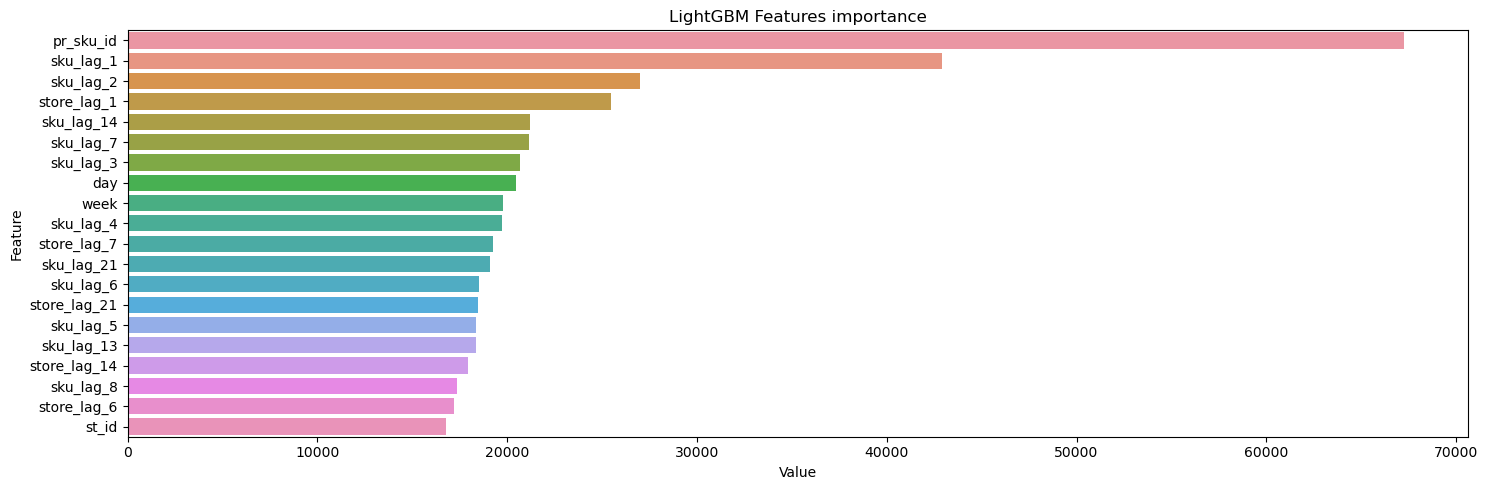

In [53]:
data=with_store_lags
cols_to_drop=['date', 'sold', 'sku', 'store']
cat_features=['pr_sku_id', 'st_id', 'season', 'dow']

end_train = data['date'].max() - pd.Timedelta(days=14)
train = data[data['date'] <= end_train]
valid = data[data['date'] > end_train]

X_train = train.drop(cols_to_drop, axis=1)
y_train = train['sold']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['sold']

cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = best_model
preds = lgbm_reg.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

plotImp(lgbm_reg, X_train)

Здесь сохраняется та же логика кросс-валидации, которую мы применяли для предыдущей модели: мы выделили в качестве валидационной выборки последние 14 дней, оставив все предшествующие данные в обучающей выборке. Для второго фолда кросс-валидации мы сдвинули валидационную выборку на две недели раньше, тем самым на 14 дней сократив обучающую. Таким образом мы в цикле последовательно формируем 5 фолдов кросс-валидации, обучаем на хронологически первых данных градиентный бустинг, валидируем его на последних 14 днях и оцениваем важность признаков в порядке от наиболее к наименее важным. По изменениям метрики и графику важности признаков мы оцениваем признаки, добавленные в данной итерации. Наблюдения за процессом записаны в ячейке под обучением

Наиболее важным представляется категориальный признак товар, затем его продажи вчера и позавчера. Это кажется логичным: прогноз основывается на том, как товар обычно продается, как продавался в последние дни. Важны лаги, кратные 7, что указывает на сильную недельную сезонность. На самом деле это даже может быть проблемой: когда мы смотрим на графики прогнозов нашей модели, мы мало что видим, кроме двух небольших пиков в выходные. Продажи магазина кажутся менее значимыми, чем продажи товара по всем магазинам, однако вчерашние продажи магазина и продажи неделю назад все же вошли в топ. Из календарных признаков важны день месяца и номер недели - есть тренд и месячная сезонность

### Forecasting

In [54]:
#get lines from submission form
updated_sub = pd.read_csv('updated_sub.csv')
updated_sub['date'] = pd.to_datetime(updated_sub['date']).dt.normalize()
updated_sub['store_item'] = updated_sub['st_id'].str.cat(updated_sub['pr_sku_id'], sep='-')
updated_sub.head()

,st_id,pr_sku_id,date,target,store_item
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,NaN,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,2.0,16a5cdae362b8d27a1d8f8c7b78b4330-00661699f5437...
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,7.0,16a5cdae362b8d27a1d8f8c7b78b4330-0094042bfeae5...
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,NaN,16a5cdae362b8d27a1d8f8c7b78b4330-0169529ff660a...
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,6.0,16a5cdae362b8d27a1d8f8c7b78b4330-01e4734745e97...


In [69]:
#take only those lines we didn't fill in the previous part
nonflagman_sub = updated_sub[updated_sub['target'].isna()]
nonflagman_sub.shape

(32774, 5)

In [70]:
#make sure there are 14-days forecast periods for each of item-store pairs
nonflagman_sub['store_item'].nunique() * 14

32774

In [71]:
def preprocess_test_by_sku(pred_with_history):    
    #index needs to be reset, as for non-first lines in a forecast they are equal
    pred_with_history = pred_with_history.reset_index(drop=True)

    #add lags - sku
    pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]].fillna(method='ffill')
    pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]].shift(1, axis=1)
    pred_with_history.loc[pred_with_history.index[-1], 'sku_lag_1'] = pred_with_history.loc[pred_with_history.index[0], 'sku']

    #add features of day-of-week, day-of-month, week, month, season
    pred_with_history['dow'] = pred_with_history['date'].dt.dayofweek
    pred_with_history['day'] = pred_with_history['date'].dt.day
    pred_with_history['week'] = pred_with_history['date'].dt.isocalendar().week.astype('int32')
    pred_with_history['month'] = pred_with_history['date'].dt.month
    pred_with_history['season'] = pred_with_history['date'].dt.quarter    
    
    #drop upper row
    pred_with_history = pred_with_history.drop(pred_with_history.index[0], axis=0)    

    return(pred_with_history)

In [72]:
def preprocess_test_by_store(pred_with_history):    
    #index needs to be reset, as for non-first lines in a forecast they are equal
    pred_with_history = pred_with_history.reset_index(drop=True)

    #add lags - store
    pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]].fillna(method='ffill')
    pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]].shift(1, axis=1)
    pred_with_history.loc[pred_with_history.index[-1], 'store_lag_1'] = pred_with_history.loc[pred_with_history.index[0], 'store']
    
    #drop upper row
    pred_with_history = pred_with_history.drop(pred_with_history.index[0], axis=0)    

    return(pred_with_history)

In [73]:
#this is what we'll get as input
nonflagman_sub = nonflagman_sub.drop('store_item', axis=1)
first_pred = nonflagman_sub[nonflagman_sub['date'] == nonflagman_sub['date'].min()].head(1)
first_pred

,st_id,pr_sku_id,date,target
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-19,NaN


In [74]:
def make_forecast_for_sample_row(line_from_submission, h=14):
    forecast = pd.DataFrame()
    row = line_from_submission.copy()
    start_date = row['date']
    
    for i in range(h):
        row['date'] = start_date + pd.Timedelta(days=1*i)
        lower_row = row.copy()

        #if first line take lags from the last line of train. otherwise from previous predicted line
        #first match sku to get sku lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['pr_sku_id'] == lower_row['pr_sku_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, lower_row])        
        sku_preprocessed = preprocess_test_by_sku(pred_with_history)

        #now match store to get store lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['st_id'] == lower_row['st_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, sku_preprocessed])        
        last_preprocessed = preprocess_test_by_store(pred_with_history)
        
        #drop columns before model
        X_test = last_preprocessed.drop(['date', 'sold', 'sku', 'store', 'target'], axis=1)

        #fix categorical
        for col in cat_features:
            X_test[col] = pd.Categorical(X_test[col])
            
        pred = lgbm_reg.predict(X_test)

        #prediction becomes "fact" of the day we forecast to become lag_1 for the next day. also it goes to forecast table as target
        last_preprocessed['sold'] = round(pred.item())
        row['target'] = round(pred.item())
        
        forecast = pd.concat([forecast, row])
        
    return forecast

make_forecast_for_sample_row(first_pred)

,st_id,pr_sku_id,date,target
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-19,2
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,3
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-21,4
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-22,3
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-23,3
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-24,2
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-25,3
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-26,3
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-27,3
24968,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-28,3


In [75]:
#lets fill submission file with forecasts. na sum shows how many values are left
updated_sub.isna().sum()

st_id             0
pr_sku_id         0
date              0
target        32774
store_item        0
dtype: int64

In [76]:
#here are pairs we're going to predict with this model
nonflagman_sub = nonflagman_sub.groupby(['st_id', 'pr_sku_id'])['date'].min().reset_index()
nonflagman_sub.head()

,st_id,pr_sku_id,date
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-19
1,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-19
2,16a5cdae362b8d27a1d8f8c7b78b4330,02713435f3587e2c81d8f6a9016763ea,2023-07-19
3,16a5cdae362b8d27a1d8f8c7b78b4330,0448c8afc036bb44c457d7e9edd74c50,2023-07-19
4,16a5cdae362b8d27a1d8f8c7b78b4330,050a8120e2a3b8751df8752fcc0323ef,2023-07-19


In [77]:
nonflagman_sub.shape

(2341, 3)

In [78]:
common_forecast = pd.DataFrame()
for index, row in nonflagman_sub.iterrows():
    try:
        forecast = make_forecast_for_sample_row(pd.DataFrame({'st_id': row['st_id'], 'pr_sku_id': row['pr_sku_id'], 'date': row['date'], 'target': np.nan}, index=[0]))    
        common_forecast = pd.concat([common_forecast, forecast])
    except:
        continue
    

In [79]:
#check that there are 14 days of forecast for each pair of 2341
common_forecast.date.value_counts()

date
2023-07-19    1763
2023-07-20    1763
2023-07-21    1763
2023-07-22    1763
2023-07-23    1763
2023-07-24    1763
2023-07-25    1763
2023-07-26    1763
2023-07-27    1763
2023-07-28    1763
2023-07-29    1763
2023-07-30    1763
2023-07-31    1763
2023-08-01    1763
Name: count, dtype: int64

In [80]:
#update submission
updated_sub = updated_sub.merge(common_forecast, on=['st_id', 'pr_sku_id', 'date'], how='left')
updated_sub.isna().sum()

st_id             0
pr_sku_id         0
date              0
target_x      32774
store_item        0
target_y      19012
dtype: int64

In [89]:
#return to original columns
new_updated_sub = updated_sub.copy()
new_updated_sub['isna_sum'] = new_updated_sub.isna().sum(axis=1)
new_updated_sub['target_x'] = new_updated_sub[['target_x', 'target_y']].sum(axis=1)
new_updated_sub = new_updated_sub.rename(columns={'target_x': 'target'}).drop(['target_y', 'store_item'], axis=1)
new_updated_sub['target'] = new_updated_sub.apply(lambda x: np.nan if x['isna_sum'] == 2 else x['target'], axis=1)
new_updated_sub.isna().sum()

st_id           0
pr_sku_id       0
date            0
target       8092
isna_sum        0
dtype: int64

У нас осталось достаточно много незаполненных строк. Это строки, попавшие при прогнозе в исключение - для товаров не нашлись данные в последний день обучающей выборки, 2023-07-18. Подтянем для них временные ряды, ранее заполненные нулями. Для этого необходимо изменить функцию прогноза

In [90]:
def make_last_forecast(line_from_submission, h=14):
    forecast = pd.DataFrame()
    row = line_from_submission.copy()
    start_date = row['date']
    
    for i in range(h):
        row['date'] = start_date + pd.Timedelta(days=1*i)
        lower_row = row.copy()

        #this is what we change. look for lags not in train dataset, but in byproduct where we filled missing days with zeros
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = byproduct[(byproduct['pr_sku_id'] == lower_row['pr_sku_id'].item()) & 
                                        (byproduct['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, lower_row])        
        sku_preprocessed = preprocess_test_by_sku(pred_with_history)

        #now match store to get store lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['st_id'] == lower_row['st_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, sku_preprocessed])        
        last_preprocessed = preprocess_test_by_store(pred_with_history)
        
        #drop columns before model
        X_test = last_preprocessed.drop(['date', 'sold', 'sku', 'store', 'target'], axis=1)

        #fix categorical
        for col in cat_features:
            X_test[col] = pd.Categorical(X_test[col])
            
        pred = lgbm_reg.predict(X_test)

        #prediction becomes "fact" of the day we forecast to become lag_1 for the next day. also it goes to forecast table as target
        last_preprocessed['sold'] = round(pred.item())
        row['target'] = round(pred.item())
        
        forecast = pd.concat([forecast, row])
        
    return forecast

In [92]:
#form dataset for which forecast is not filled
rare_sku_sub = new_updated_sub[new_updated_sub['target'].isna()]
rare_sku_sub = rare_sku_sub.groupby(['st_id', 'pr_sku_id'])['date'].min().reset_index()
rare_sku_sub.head()

,st_id,pr_sku_id,date
0,16a5cdae362b8d27a1d8f8c7b78b4330,0696efaa77a5d9e6590cb1654125146d,2023-07-19
1,16a5cdae362b8d27a1d8f8c7b78b4330,072e81e77edf6f7370bc290b32c9bb81,2023-07-19
2,16a5cdae362b8d27a1d8f8c7b78b4330,15f0c24e521b6f8b4379a0d4958fbae9,2023-07-19
3,16a5cdae362b8d27a1d8f8c7b78b4330,16939b73c086c005ffeda3375320816d,2023-07-19
4,16a5cdae362b8d27a1d8f8c7b78b4330,18263c76c0db10f61f721741382c091f,2023-07-19


In [93]:
rare_sku_sub.shape, 8092 / 14

((578, 3), 578.0)

In [94]:
common_forecast = pd.DataFrame()
for index, row in rare_sku_sub.iterrows():
    try:
        forecast = make_last_forecast(pd.DataFrame({'st_id': row['st_id'], 'pr_sku_id': row['pr_sku_id'], 'date': row['date'], 'target': np.nan}, index=[0]))    
        common_forecast = pd.concat([common_forecast, forecast])    
    except:
        continue

In [95]:
#check that there are 14 days of forecast for each pair of remaining 578
common_forecast.date.value_counts()

date
2023-07-19    482
2023-07-20    482
2023-07-21    482
2023-07-22    482
2023-07-23    482
2023-07-24    482
2023-07-25    482
2023-07-26    482
2023-07-27    482
2023-07-28    482
2023-07-29    482
2023-07-30    482
2023-07-31    482
2023-08-01    482
Name: count, dtype: int64

In [96]:
#update submission
new_updated_sub = new_updated_sub.merge(common_forecast, on=['st_id', 'pr_sku_id', 'date'], how='left')
new_updated_sub.isna().sum()

st_id            0
pr_sku_id        0
date             0
target_x      8092
isna_sum         0
target_y     36946
dtype: int64

In [98]:
#return to original columns
last_updated_sub = new_updated_sub.copy()
last_updated_sub['isna_sum'] = last_updated_sub.isna().sum(axis=1)
last_updated_sub['target_x'] = last_updated_sub[['target_x', 'target_y']].sum(axis=1)
last_updated_sub = last_updated_sub.rename(columns={'target_x': 'target'}).drop(['target_y'], axis=1)
last_updated_sub['target'] = last_updated_sub.apply(lambda x: np.nan if x['isna_sum'] == 2 else x['target'], axis=1)
last_updated_sub.isna().sum()

st_id           0
pr_sku_id       0
date            0
target       1344
isna_sum        0
dtype: int64

In [101]:
last_updated_sub = last_updated_sub.fillna(0).drop('isna_sum', axis=1)
last_updated_sub.isna().sum()

st_id        0
pr_sku_id    0
date         0
target       0
dtype: int64

In [102]:
#save to csv
last_updated_sub.to_csv('submission.csv', index=False)

Эту часть мы планируем улучшить, однако в целях облегчения ревью опишем, что происходит в ней сейчас:

1) мы выделяем в датасет nonflagman_sub пары товар-магазин, для которых создана эта модель модель, не вошедшие в топ и с разреженными временными рядами

2) для каждой строки из тестовой выборки необходимо создать фичи по образу обучающей выборки. Здесь есть отличие от предыдущей модели. К каждой строке мы отдельно подбираем данные по товару и по магазину в предыдущий день (не по паре товар-магазин, как в первой модели). Если речь идет о первом дне прогноза, данные берем из последнего дня обучающей выборки. Для дней прогноза со 2 по 14 основанием для создания лагов и скользящих средних является предыдущая строка прогноза. Предобработка столбцов задана в функции preprocess_test. Функция make_forecast_for_sample_row принимает на вход строку из списка целевых пар и выдает датафрейм прогноза на 14 дней

3) мы итерируемся по списку пар товар-магазин и, выводя прогноз для каждой из них, конкатенируем их в единый датафрейм

4) соединяем датафрейм submission с полученным прогнозом, заполняя часть значений в столбце target

5) если в первой модели мы на этом закончили, то здесь мы сталкиваемся с проблемой: у нас остались незаполненные строки прогноза. Это связано с тем, что не все фичи для тестовых строк удалось заполнить. Данные о продажах по магазину за вчера есть для всех пар, чего нельзя сказать о данных по товару. Некоторые товары не продавались в последний день обучающего датасета ни в одном магазине. Для таких случаев мы обращаемся к ранее созданному датасету byproduct, в котором разреженные временные ряды заполнены нулями. Возможно, нам следует сделать это сразу, сняв необходимость этой второй итерации

6) однако и после этого информация о порядка 100 товаров не была найдена - проверяем в исходном датасете sales: это товары, которые не продавались никогда и нигде. Прогноз продаж новых товаров - это отдельная сложная задача, вернемся к ней позже. Пока для простоты будем считать, что если что-то никогда не пользовалось спросом, то нет оснований полагать, что завтра вдруг начнем, и заполним эти строки нулями.

### to do

* закончить процесс формирования признаков для второй модели

* экспериментировать с разбивкой второй модели по кластерам

* попробовать другие алгоритмы ML, кроме градиентного бустинга

* использовать модели типа Аримы/Профета для прогноза цены вместо заглушки

* проработать проблему прогнозирования спроса на новые товары

* сделать кросс-валидацию 14-шаговой в соответствии с алгоритмом прогнозирования

* рассмотреть варианты рефакторинга алгоритма прогнозирования

* упаковать полученную модель (модели) в docker контейнер